# Session 5 : Pre-processing

>Intelligence Artificielle & Machine Learning pour la modélisation de séries temporelles et de signaux<br />
>Master 1 Parcours IA ENS Paris Saclay<br />
>Laurent Oudre (laurent.oudre@ens-paris-saclay.fr)

This fifth session is related to all pre-processing steps that can be used to transform a raw signal into a signal of interest for machine learning algorithms : denoising, detrending, removal of impulsive noise, interpolation and change point detection. Slides are available at http://www.laurentoudre.fr/signalml.html

1. **Library and data loading**
2. **Exploratory study**
3. **Denoising**
4. **Detrending**
5. **Detection and removal of impulsive noise**
6. **Change point detection**

## 1. Library and data loading

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from statsmodels.regression.linear_model import yule_walker
import ruptures as rpt

In [2]:
plt.rcParams['figure.figsize'] = (10,5)

In [3]:
# Data loading
npzfile = np.load('Session5.npz')
x=npzfile['x']
t=npzfile['t']
y1=npzfile['y1']
y2=npzfile['y2']
y3=npzfile['y3']
y4=npzfile['y4']
n=(np.sort(np.round(npzfile['n']))-1).astype(int)
n2=[39, 136, 255, 300]
Fs=npzfile['Fs']

# First investigations
N=np.size(x)
print("Sampling Frequency : {Fs} Hz".format(**locals()))
print("Number of samples : {N}".format(**locals()))

Sampling Frequency : 100 Hz
Number of samples : 300


## 2. Exploratory study

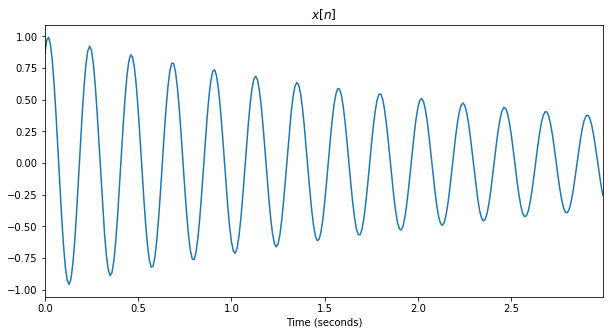

In [4]:
# x[n] as a function of time
plt.plot(t,x)
plt.xlim((0,(N-1)/Fs))
plt.xlabel('Time (seconds)')
plt.title('$x[n]$')
plt.show()

## 3. Denoising

A popular solution for denoising a signal consists in filtering the signal with appropriate cut frequencies. One practical procedure is to study the PSD of the noisy signal in order to estimate the frequency bands that are unlikely to belong to the signal.

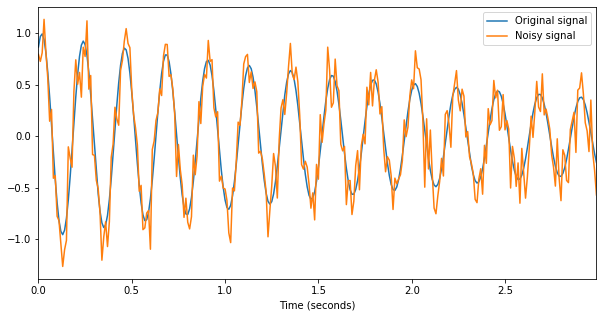

In [5]:
# Plot of the original and noisy signals
plt.plot(t,x)
plt.plot(t,y1)
plt.xlim((0,(N-1)/Fs))
plt.xlabel('Time (seconds)')
plt.legend(('Original signal', 'Noisy signal'))
plt.show()

In [6]:
# Periodogram function
def periodogram(x,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    X=np.fft.fftshift(X)
    Gammax=(np.abs(X)**2)/N
    # Computation the frequency vector
    f=np.fft.fftfreq(N, d=1/Fs)
    f=np.fft.fftshift(f)
    return Gammax,f  

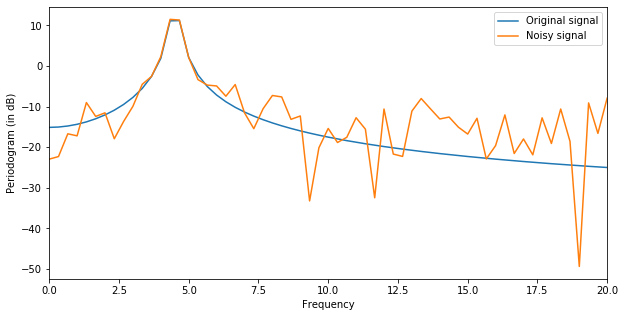

In [21]:
# Plots of the periodograms of x[n] and y[n]
Gammax,f=periodogram(x,Fs)
Gammay,f=periodogram(y1,Fs)
plt.plot(f,10*np.log10(Gammax))
plt.plot(f,10*np.log10(Gammay))
plt.ylabel('Periodogram (in dB)')
plt.xlabel('Frequency')
plt.xlim((0,20))
plt.legend(('Original signal', 'Noisy signal'))
plt.show()

According to the PSD, it appears that most of the power of the original signal lies in the frequency band before 10 Hz: the remaining content is likely to be only composed of noise. Therefore, we can perform denoising by applying a low-pass filter

In [22]:
def low_pass_filter(x,fc,Fs):
    wc=fc/(Fs/2)
    b, a = signal.butter(4, wc, 'low')
    y = signal.filtfilt(b, a, x)
    return y    

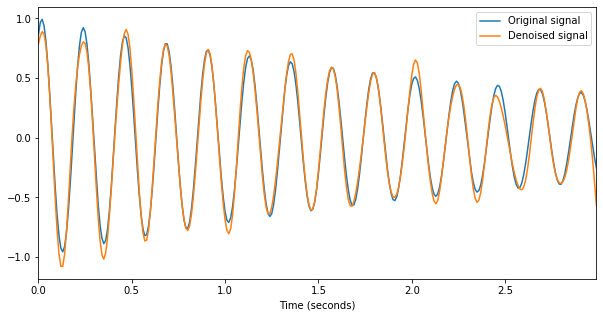

In [23]:
# Low-pass filter with cut frequency fc = 10Hz
fc=10
x1_hat=low_pass_filter(y1,fc,Fs)

plt.plot(t,x)
plt.plot(t,x1_hat)
plt.xlim((0,(N-1)/Fs))
plt.xlabel('Time (seconds)')
plt.legend(('Original signal', 'Denoised signal'))
plt.show()

## 4. Detrending

Trends can be removed either by using low-pass filtering or by using a regression on a set of smooth functions such as polynoms (see Session 3) so as to extract the trend component

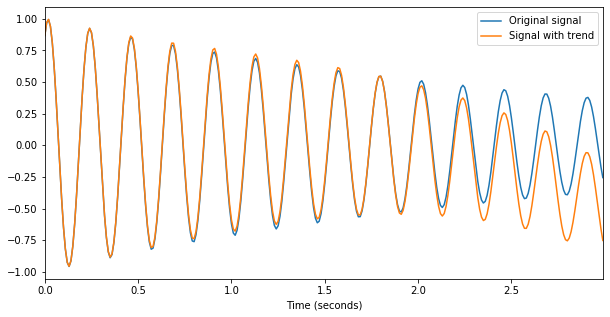

In [10]:
# Plot of the original and trend signals
plt.plot(t,x)
plt.plot(t,y2)
plt.xlim((0,(N-1)/Fs))
plt.xlabel('Time (seconds)')
plt.legend(('Original signal', 'Signal with trend'))
plt.show()

In [11]:
# Regression on polynomial functions
D=np.zeros((N,5))
D[:,0]=np.ones(N)
D[:,1]=t
D[:,2]=np.power(t,2)
D[:,3]=np.power(t,3)
D[:,4]=np.power(t,4)
    
alpha=np.dot(np.linalg.inv(np.dot(np.transpose(D),D)),np.dot(np.transpose(D),y2)) #Regression parameters
alpha

array([ 0.22166171, -0.98128453,  1.29171137, -0.60672386,  0.08742166])

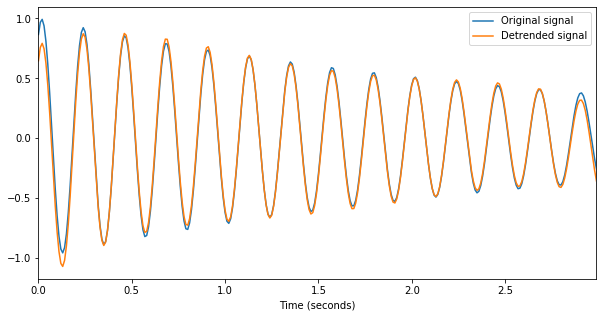

In [14]:
x2_hat=np.dot(D,alpha); #Reconstruction
plt.plot(t,x)
plt.plot(t,y2-x2_hat)
plt.xlim((0,(N-1)/Fs))
plt.xlabel('Time (seconds)')
plt.legend(('Original signal', 'Detrended signal'))
plt.show()

## 5. Detection and removal of impulsive noise

Impulsive noise of small lengths (several samples) can be suppressed by applying non linear filters such as median filters. In case of large bursts (more than 10 samples), impulsive noise has to be handled in two phases : detection (finding the locations of the corrupted samples) and interpolation (replacing corrupted samples with more appropriate values). 

* **Detection phase :** given estimates of the AR parameters, computation of the quantity $$d[n]=x[n]+\sum_{i=1}^p \hat{a}_i x[n-i]$$ The set of corrupted samples can determined as $$\mathcal{T} = \left\lbrace n \mbox{ s.t. } |d[n]|>\lambda \right\rbrace$$
* **Interpolation phase :** minimization of the quantity $$\sum_{n=p+1}^{N-1}\left|x[n] + \sum_{i=1}^p \hat{a}_i x[n-i]\right|^2$$

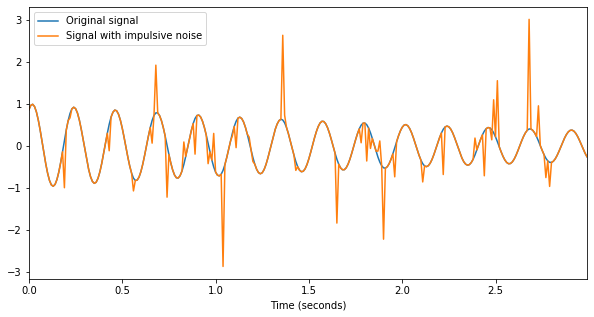

In [206]:
# Plot of the original and noisy signals
plt.plot(t,x)
plt.plot(t,y3)
plt.xlim((0,(N-1)/Fs))
plt.xlabel('Time (seconds)')
plt.legend(('Original signal', 'Signal with impulsive noise'))
plt.show()

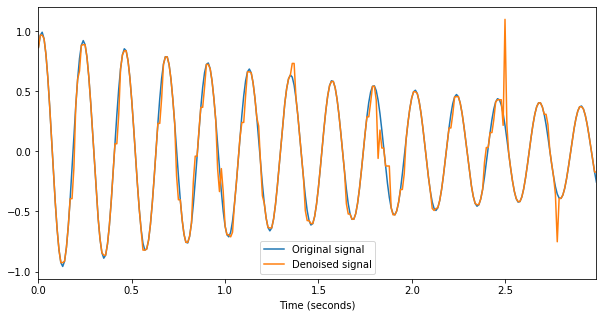

In [207]:
# Naive approach : Median filtering
x3_hat=signal.medfilt(y3,3)
plt.plot(t,x)
plt.plot(t,x3_hat)
plt.xlim((0,(N-1)/Fs))
plt.xlabel('Time (seconds)')
plt.legend(('Original signal', 'Denoised signal'))
plt.show()

In [208]:
# Detection of corrupted samples based on AR model
def detection_impulsive(x,p,K):
    # Estimation of the AR parameters
    a, sigma_e = yule_walker(x, p, method='mle',demean=False) 
    Nw=np.size(x)
    # Computation of the prediction error
    d=np.zeros((Nw,))
    for j in range(p,Nw):
        d[j]=x[j]-np.sum(np.dot(x[j-p:j],np.flip(a)))
    d=np.abs(d)
    # Thresholding the prediction error to find the locations of the corrupted samples
    lambda_K=K*sigma_e
    T=np.where(d>lambda_K)
    T=T[0]
    T=T[(T>p-1) & (T<Nw-p)]
    return T

[ 19  43  66  68  74  89  96  99 104 105 111 136 165 181 190 196 211 222
 244 249 251 252 253 254 268 269 270 273 278 279]
[ 19  22  43  56  66  68  74  83  89  96  99 104 109 111 118 120 136 137
 143 165 178 181 183 187 188 190 196 211 222 239 242 244 248 249 251 268
 273 277 279]


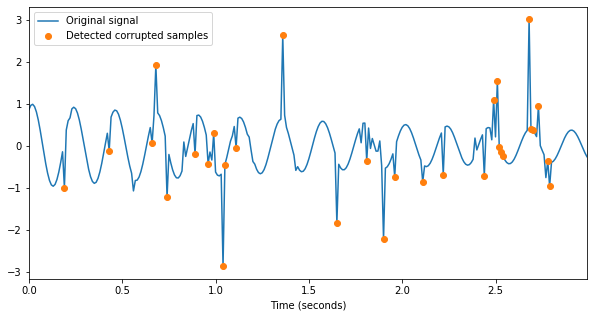

In [239]:
p=10 # Order of the model
K=1 # Detection threshold
T=detection_impulsive(y3,p,K)
print(T) # Detected corrupted samples
print(n) # Real corrupted samples
plt.plot(t,y3)
plt.plot(t[T],y3[T],'o')
plt.xlim((0,(N-1)/Fs))
plt.xlabel('Time (seconds)')
plt.legend(('Original signal', 'Detected corrupted samples'))
plt.show()

In [232]:
# Interpolation based on AR model
def interpolation_impulsive(x,p,T):
    a, sigma_e = yule_walker(x, p, method='mle',demean=False)
    Nw=np.size(x)
    a=np.concatenate(([1],-a))
    m=np.size(T)
    b=np.zeros((p+1,))
    for i in range(p+1):
        b[i]=np.sum(np.dot(a[0:p-i+1],a[i:p+1]))

    B=np.zeros((m,m))
    for i in range(m):
        for j in range(m):
            if np.abs(T[i]-T[j])<p+1:
                B[i,j]=b[np.abs(T[i]-T[j])]

    z=np.zeros((m,))
    for i in range(m):
        for k in range(-p,p+1):
            if np.all(T!=T[i]-k):
                z[i]=z[i]+b[np.abs(k)]*x[T[i]-k]
    
    y=-np.dot(np.linalg.inv(B),z);
    return y

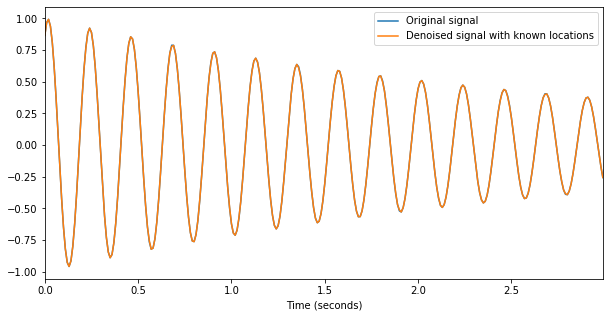

In [241]:
# Interpolation when the locations of corrupted samples are known
p=10 # Order of the model
y3_hat=interpolation_impulsive(y3,p,n)
x3_hat=np.copy(x)
x3_hat[n]=y3_hat
plt.plot(t,x)
plt.plot(t,x3_hat)
plt.xlim((0,(N-1)/Fs))
plt.xlabel('Time (seconds)')
plt.legend(('Original signal', 'Denoised signal with known locations'))
plt.show()

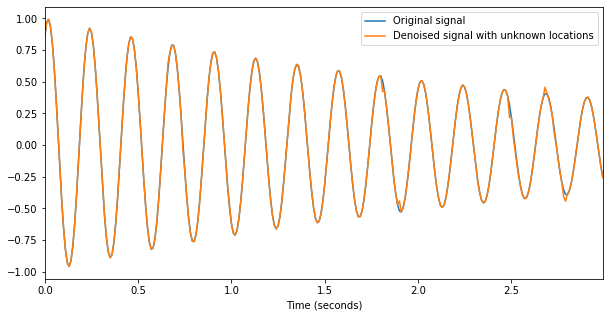

In [240]:
# Interpolation when the locations of corrupted samples are unknown
p=10 # Order of the model
K=1 # Detection threshold
T=detection_impulsive(y3,p,K)
y3_hat=interpolation_impulsive(y3,p,T)
x3_hat=np.copy(x)
x3_hat[T]=y3_hat
plt.plot(t,x)
plt.plot(t,x3_hat)
plt.xlim((0,(N-1)/Fs))
plt.xlabel('Time (seconds)')
plt.legend(('Original signal', 'Denoised signal with unknown locations'))
plt.show()


## 6. Change point detection

The problem of change point detection consists in finding the locations $\mathcal{T}^* = \left( t^*_1, \ldots, t^*_{K^*}\right) $ of the $K^*$ change point occuring in the signal. This problem can be seen as an optimization problem
$$\left( \hat{t}_1, \ldots, \hat{t}_{K}\right)  = \underset{\left( t_1, \ldots, t_{K}\right)}{\operatorname{argmin}} \sum_{k=0}^{K} \ c(x[t_{k}..t_{k+1}])$$
This problem can be solved through dynamic programming and relies on a cost function $c(.)$ that determines the type of changes that we seek to find in the signal. Popular choice is the $L_2$ norm : $c(.) = \| . \|_2^2$.

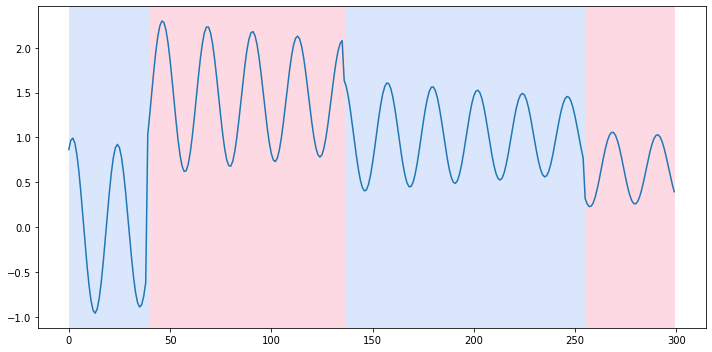

In [261]:
# Plot of a non-stationary signal 
rpt.show.display(y4, n2, [0, 300], figsize=(10, 5))
plt.show()

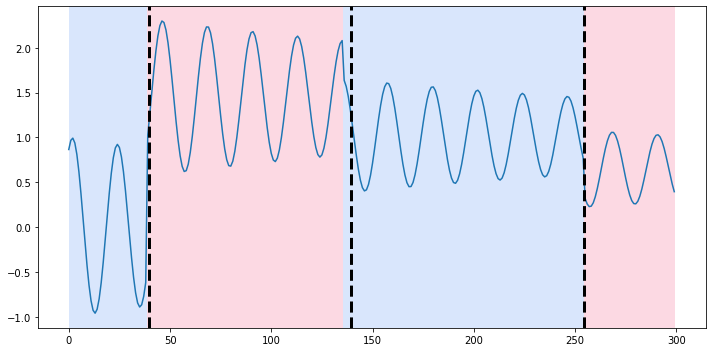

In [263]:
# Change point detection with L2 cost function and K=3 breakpoints 
algo = rpt.Dynp(model='l2', min_size=3).fit(y4)
my_bkps = algo.predict(n_bkps=3)
rpt.show.display(y4, n2, my_bkps, figsize=(10, 5))
plt.show()